# Towards an ICCM paper

This notebook will have two parts. The first will make predictions about reading times (to start, for local coherence effects) from the equations of motion. The second will test the hypothesis that, in the model, the average reading time is monotonically dependent on the relative harmony values of two competing peaks.

To test both of these ideas, we'll use a 2D harmony landscape with two attractors, one at [1, 0] and the other at [0, 1]. The attractor at [1, 0] will be the grammatical parse $\mathbf{x}_g$, and [0, 1] will be the ungrammatical parse $\mathbf{x}_u$.

## Part the first: A line integral approach to predicting reading times

(This is taken largely from [here](http://tutorial.math.lamar.edu/Classes/CalcIII/LineIntegralsPtI.aspx) and Boas (1983, *Mathematical methods in the physical sciences*, Wiley).

The time to travel some distance along a curve $C$ is equal to the distance traveled divided by the speed of travel. Thus, we're looking for an equation of the form $T = dist / speed$. In the general case of $n$-dimensions, this will be a path integral $T = \int_C \mathbf{F}\cdot d\mathbf{r}$, where $\mathbf{F}$ is some vector field and $d\mathbf{r}$ is derivative along the curve $C$, where $C$ has been parameterized using some function $\mathbf{r}(t)$. Ideally, we would define the curve $C$ to be the actual path defined by the dynamics, but that would require an explicit solution to the differential equation $\dot{\mathbf{x}} = \nabla H(\mathbf{x})$, which we don't have. Instead, I'm approximating the actual solution curve with a straight line connecting the initial state $\mathbf{x}_{init}$ and some final state $\mathbf{x}_{fin}$ close to $\mathbf{x}_g$ or $\mathbf{x}_u$.

We want to see how long it takes to get from $\mathbf{x}_{init}$ to $\mathbf{x}_{fin}$, so the force $\mathbf{F}$ from above becomes $\nabla H(\mathbf{x})^{-1}$:
$$
T = \int_C \nabla H(\mathbf{x})^{-1}\cdot d\mathbf{r}
$$
We need to make $H(\cdot)^{-1}$ a function of the 1D position along the curve, so that means writing each element $x_j$ of the state vector $\mathbf{x}$ as function of that position. This position along the curve is given by 
$$
\mathbf{r}(t) = (1 - t)\mathbf{x}_{init} + t\mathbf{x}_{fin}
$$
for $0 \leq t \leq 1$. Note that this parameterization equals $\mathbf{x}_{init}$ at $t = 0$ and $\mathbf{x}_{fin}$ at $t = 1$. With 
$$
d\mathbf{r} = (-\mathbf{x}_0 + \mathbf{x}_1) dt
$$
the integral becomes
$$
T = \int_0^1 \left(\nabla H(\mathbf{r}(t))^{-1}\cdot (-\mathbf{x}_0 + \mathbf{x}_1)\right)dt
$$
which can be evaluated numerically.

In [101]:
# Setting up things in SymPy
from sympy import *
from IPython.display import display

# Declaring scalars
# x0, x1 are the dimensions
x0, x1, h0, h1, gamma, t = symbols('x0 x1 h0 h1 gamma t')  # make these formal symbols for SymPy to manipulate
# x{0, 1}{i, f} are the initial and final positions for the two spatial dimensions
x0i, x1i, x0f, x1f = symbols('x0i x1i x0f x1f')
h0 = 1.0
h1 = 0.5  # For initial testing
gamma = 0.25

# Declaring vectors
x = Matrix([x0, x1])  # state vector
cg = Matrix([1, 0])  # centers of the RBFs
cu = Matrix([0, 1])
xinit = Matrix([x0i, x1i])  # placeholders for now
xfin = Matrix([x0f, x1f])
t1 = Matrix([1-t, 1-t])  # Vectors for calculating r(t)
justt = Matrix([t, t])

H = h0*exp(-(x-cg).dot(x-cg) / gamma) + h1*exp(-(x-cu).dot(x-cu) / gamma)  # defining the harmony function
dxdt = Matrix([diff(H, i) for i in x])
r = xinit.multiply_elementwise(t1) + xfin.multiply_elementwise(justt)
dr = (-xinit + xfin)
display(H, dxdt, r, dr)

0.5*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)

Matrix([
[-4.0*x0*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*(-8.0*x0 + 8.0)*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)],
[-8.0*x1*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2) + 0.5*(-8.0*x1 + 8.0)*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2)]])

Matrix([
[t*x0f + x0i*(-t + 1)],
[t*x1f + x1i*(-t + 1)]])

Matrix([
[x0f - x0i],
[x1f - x1i]])

In [102]:
# Calculating the locations of the fixed points
xg = nsolve(dxdt, x, (1, 0))
xu = nsolve(dxdt, x, (0, 1))
xmid = nsolve(dxdt, x, (0.5, 0.5))
print('x_g = {}\nx_u = {}\nsaddle = {}'.format(xg, xu, xmid))

x_g = Matrix([[0.999831845081734], [0.000168154918266462]])
x_u = Matrix([[0.000677780997818818], [0.999322219002181]])
saddle = Matrix([[0.442150996291071], [0.557849003708929]])


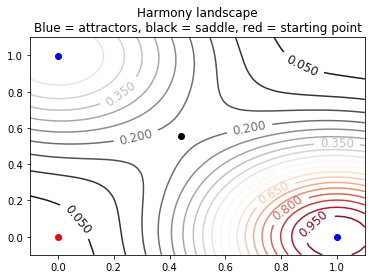

In [103]:
# Plotting the harmony landscape and fixed points
import matplotlib.pyplot as plt
from itertools import product

Hnum = lambdify(x, H)  # Making a numerical version of the symbolic function
delta = 0.025  # Grid size for calculating the harmony
xx1 = np.arange(-0.1, 1.1, delta)
xx2 = np.arange(-0.1, 1.1, delta)
Z = np.zeros((len(xx1), len(xx2)))  # Harmony
for i, j in product(range(len(xx1)), range(len(xx2))):
    Z[i, j] = Hnum(xx1[i], xx2[j])


# Making the contour plot
clines = plt.contour(xx1, xx2, Z.T, 20, cmap='RdGy_r')
plt.clabel(clines, clines.levels[::3], inline=True, fontsize=12)
# Marking the fixed pts.
plt.plot(xg[0], xg[1], marker='o', color='blue')
plt.plot(xu[0], xu[1], marker='o', color='blue')
plt.plot(xmid[0], xmid[1], marker='o', color='k')
plt.plot(0, 0, marker='o', color='red')  # init. condition
plt.title('Harmony landscape\nBlue = attractors, black = saddle, red = starting point')
plt.show()

In [104]:
# Now we can calculate the integral shown above
# Takes a few seconds...
import numpy as np
integrand = Matrix(np.reciprocal(dxdt.subs({x0: r[0], x1: r[1]})))
integrand.dot(dr)  # 
integrand_g = (integrand.dot(ds)).subs({x0i: 0, x1i: 0, x0f: xg[0]-0.1, x1f: xg[1]-0.1})
Tg = Integral(integrand_g, (t, 0, 1)).evalf()
integrand_u = (integrand.dot(ds)).subs({x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to grammatical = {}\nTime to ungrammatical = {}'.format(Tg, Tu))

Time to grammatical = 0.618841121217809
Time to ungrammatical = 2.24774354722145


In [105]:
# Changing the harmony height of the ungrammatical parse:
integrand_u = (integrand.dot(ds)).subs({h1: 0.25, x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu2 = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to ungrammatical (h1 = 0.25) = {}'.format(Tu2))

Time to ungrammatical (h1 = 0.25) = 5.58320971411626


### Summing up so far

So, it looks like the line integral approach is making coherent predictions about settling times to different attractors: Higher-harmony attractors are approached faster than lower-harmony ones.

The overall theory of reading times here is that the overall average time is the weighted average of how long it takes to settle to each attractor weighted by how often the system goes to that attractor. We now have predictions about how fast it takes to get to each attractor, now we want to look at how often it goes to each one.

## Part the second: Relative harmony heights and reading times